In [1]:
import cv2
import face_recognition
import os

In [2]:
#THis code is to check if the video is corrupted or not..
#If the video is corrupted delete the video.
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
#Check if the file is corrupted or not
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count = 20
      video_path = vid_path
      frames = []
      a = int(100/count)
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames
#extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
video_fil = glob.glob('set/*mp4')
# video_fil = glob.glob('data/Celeb_real_face_only/*.mp4')
# video_fil += glob.glob('data/DFDC_FAKE_Face_only_data/*.mp4')
# video_fil += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
# video_fil += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')
print("Total no of videos :" , len(video_fil))
print(video_fil)
count = 0;
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_fil) - count))

Total no of videos : 22
['set\\id0_0001.mp4', 'set\\id0_0002.mp4', 'set\\id0_0003.mp4', 'set\\id0_0004.mp4', 'set\\id0_id16_0000.mp4', 'set\\id0_id1_0005.mp4', 'set\\id0_id2_0005.mp4', 'set\\id0_id4_0006.mp4', 'set\\id0_id9_0002.mp4', 'set\\id1_0003.mp4', 'set\\id1_0004.mp4', 'set\\id1_0005.mp4', 'set\\id1_0006.mp4', 'set\\id1_id16_0003.mp4', 'set\\id1_id17_0002.mp4', 'set\\id1_id20_0004.mp4', 'set\\id1_id20_0009.mp4', 'set\\id1_id26_0005.mp4', 'set\\id2_0005.mp4', 'set\\id2_0006.mp4', 'set\\id2_0007.mp4', 'set\\id2_0008.mp4']
0


In [3]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import copy
import random
video_files = glob.glob('set/*mp4')
# video_files = glob.glob('data/Celeb_real_face_only/*.mp4')
# video_files += glob.glob('data/DFDC_FAKE_Face_only_data/*.mp4')
# video_files += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
# video_files += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Total no of video:  22
Average frame per video: 148.0


In [4]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_set(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = os.path.basename(video_path)
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [5]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  lab = pd.read_csv('Gobal_metadata.csv')
  fake = 0
  real = 0
  for i in data_list:
    temp_video = os.path.basename(i)
    row = lab.loc[lab['file'] == temp_video]
    label = row.iloc[0, 1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train :  17
test :  5
TRAIN:  Real: 9  Fake: 8
TEST:  Real: 3  Fake: 2


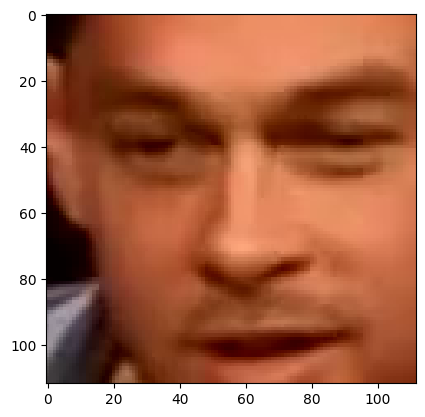

In [6]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_set(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_set(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [7]:
import torch
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        # Use ResNeXt101 as the backbone for better feature extraction
        model = models.resnext101_32x8d(weights=None)
        # Remove the final classification layer
        self.model = nn.Sequential(*list(model.children())[:-2])

        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.relu = nn.ReLU()  # Change LeakyReLU to ReLU for a more standard choice
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)  # Adjusted to handle variable latent_dim
        x_lstm, _ = self.lstm(x)
        if self.lstm.num_layers > 1:  # Check if num_layers > 1 before using dropout
            x_lstm = self.dp(x_lstm)
        # Calculate mean along the correct dimension for variable sequence lengths
        x_lstm = torch.mean(x_lstm, dim=1)
        return fmap, self.linear1(x_lstm)

In [8]:
model = Model(2).cuda()
a, b = model(torch.empty((1, 20, 3, 112, 112), device='cuda'))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

def train_epoch(epoch, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    for i, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        print(
            "\r[Epoch %d] [Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
            % (epoch, i+1, len(data_loader), losses.avg, accuracies.avg),
            end="")
    
    return losses.avg, accuracies.avg

def evaluate(data_loader, model, criterion):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            true.extend(targets.cpu().numpy())
            pred.extend(predicted.cpu().numpy())
            
            acc = calculate_accuracy(outputs, targets)
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            
    print(
        "\n[Validation] [Loss: %.4f, Acc: %.2f%%]"
        % (losses.avg, accuracies.avg)
    )
    
    return true, pred, losses.avg, accuracies.avg

class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    _, pred = outputs.max(1)
    correct = pred.eq(targets).sum().item()
    return correct / targets.size(0) * 100

# Assuming train_loader, valid_loader, model, criterion, optimizer are defined elsewhere
num_epochs = 20

model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(epoch, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    
    true, pred, test_loss, test_acc = evaluate(valid_loader, model, criterion)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)

# Continue with plotting and evaluation code as before
